In [24]:
# CELL 1: 
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
BASE_DIR = Path("/user_data/csimmon2/long_pt")
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
RSA_RESULTS = BASE_DIR / "analyses" / "rsa_corrected" / "rsa_results.pkl"

# Load RSA results
with open(RSA_RESULTS, 'rb') as f:
    rsa_data = pickle.load(f)

liu_distinctiveness = rsa_data['liu_distinctiveness']
ANALYSIS_SUBJECTS = rsa_data['ANALYSIS_SUBJECTS']

print(f"Loaded RSA data for {len(liu_distinctiveness)} subjects")

Loaded RSA data for 24 subjects


In [38]:
# CELL 2: Extract All Session-Pair Observations with Age Data
def extract_all_session_pairs_with_age(distinctiveness_data, analysis_subjects, csv_file):
    """Extract ALL consecutive session pairs with age information"""
    
    age_df = pd.read_csv(csv_file)
    observations = []
    bilateral_categories = ['object', 'house']
    
    for subject_id, categories in distinctiveness_data.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        sessions_list = info['sessions']
        
        subject_ages = age_df[age_df['sub'] == subject_id]
        if len(subject_ages) == 0:
            continue
        subject_ages = subject_ages.iloc[0]
        
        for category, sessions in categories.items():
            session_keys = sorted(sessions.keys())
            
            for i in range(len(session_keys) - 1):
                ses1 = session_keys[i]
                ses2 = session_keys[i + 1]
                
                # Map session to age column index
                ses1_idx = sessions_list.index(ses1) + 1
                ses2_idx = sessions_list.index(ses2) + 1
                
                age1 = subject_ages.get(f'age_{ses1_idx}')
                age2 = subject_ages.get(f'age_{ses2_idx}')
                
                if pd.isna(age1) or pd.isna(age2):
                    continue
                
                dist1 = sessions[ses1]['liu_distinctiveness']
                dist2 = sessions[ses2]['liu_distinctiveness']
                change = abs(dist2 - dist1)
                time_gap = age2 - age1
                
                observations.append({
                    'Subject': info['code'],
                    'Group': info['group'],
                    'Status': info['patient_status'],
                    'Hemisphere': info['hemi'],
                    'Category': category.title(),
                    'Category_Type': 'Bilateral' if category in bilateral_categories else 'Unilateral',
                    'Age_Baseline': age1,
                    'Age_Final': age2,
                    'Time_Gap_Years': time_gap,
                    'Baseline_Distinct': dist1,  # ADDED
                    'Final_Distinct': dist2,      # ADDED
                    'Repr_Change': change,
                    'Change_Per_Year': change / time_gap if time_gap > 0 else 0
                })
    
    return pd.DataFrame(observations)

print("EXTRACTING SESSION PAIRS WITH AGE DATA")
print("="*60)

all_pairs_combined = extract_all_session_pairs_with_age(liu_distinctiveness, ANALYSIS_SUBJECTS, CSV_FILE)

print(f"Total observations: {len(all_pairs_combined)}")
if len(all_pairs_combined) > 0:
    print(f"Age range: {all_pairs_combined['Age_Baseline'].min():.1f} - {all_pairs_combined['Age_Final'].max():.1f} years")
    print(f"Time gaps: {all_pairs_combined['Time_Gap_Years'].min():.2f} - {all_pairs_combined['Time_Gap_Years'].max():.2f} years")
print("\n✓ Age-mapped session pairs extracted!")

EXTRACTING SESSION PAIRS WITH AGE DATA
Total observations: 116
Age range: 7.8 - 20.0 years
Time gaps: 0.00 - 3.50 years

✓ Age-mapped session pairs extracted!


In [26]:
import pandas as pd

def extract_all_timepoints(distinctiveness_data, analysis_subjects, csv_file):
    """Extract INDIVIDUAL session data points for longitudinal plotting"""
    
    age_df = pd.read_csv(csv_file)
    observations = []
    bilateral_categories = ['object', 'house']
    
    for subject_id, categories in distinctiveness_data.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        sessions_list = info['sessions']
        
        # Get age data for this subject
        subject_ages = age_df[age_df['sub'] == subject_id]
        if len(subject_ages) == 0:
            continue
        subject_ages = subject_ages.iloc[0]
        
        for category, sessions in categories.items():
            # Iterate through ALL sessions, not just pairs
            for session_name, session_data in sessions.items():
                
                # Map session to age column index
                # Assuming session names in sessions_list match keys in distinctiveness_data
                try:
                    ses_idx = sessions_list.index(session_name) + 1
                except ValueError:
                    continue # Skip if session name not found in master list
                
                # Get Age
                current_age = subject_ages.get(f'age_{ses_idx}')
                
                # Validation
                if pd.isna(current_age):
                    continue
                
                # Get Metric (Raw Distinctiveness)
                distinctiveness = session_data['liu_distinctiveness']
                
                observations.append({
                    'Subject': info['code'],
                    'Group': info['group'],     # e.g., Patient vs Control
                    'Status': info['patient_status'],
                    'Hemisphere': info['hemi'],
                    'Category': category.title(),
                    'Category_Type': 'Bilateral' if category in bilateral_categories else 'Unilateral',
                    'Age': current_age,
                    'Distinctiveness': distinctiveness,
                    'Session': session_name
                })
    
    return pd.DataFrame(observations)

# Run the extraction
print("EXTRACTING ALL LONGITUDINAL TIMEPOINTS")
print("="*60)
df_timepoints = extract_all_timepoints(liu_distinctiveness, ANALYSIS_SUBJECTS, CSV_FILE)
print(f"Total scans extracted: {len(df_timepoints)}")
print("\n✓ Data ready for plotting!")

EXTRACTING ALL LONGITUDINAL TIMEPOINTS
Total scans extracted: 212

✓ Data ready for plotting!


In [44]:
target_key = 'sub-079' 

print(f"--- INSPECTING DATA FOR {target_key} ---")

# 1. Check if the key exists in the data dictionary
if target_key not in liu_distinctiveness:
    print(f"CRITICAL FAIL: '{target_key}' is not in liu_distinctiveness!")
else:
    print(f"✓ Found '{target_key}' in liu_distinctiveness.")
    
    # 2. Look inside the 'object' category (assuming it exists)
    if 'object' in liu_distinctiveness[target_key]:
        available_sessions = list(liu_distinctiveness[target_key]['object'].keys())
        print(f"Sessions available in 'object' category: {available_sessions}")
        
        if '02' not in available_sessions:
            print("!!! PROBLEM FOUND: Session '02' is missing from the data dictionary.")
            print("   (The code expects '02' because it is in ANALYSIS_SUBJECTS, but the data isn't there.)")
    else:
        print("Warning: 'object' category not found. Listing all categories:")
        print(liu_distinctiveness[target_key].keys())

--- INSPECTING DATA FOR sub-079 ---
✓ Found 'sub-079' in liu_distinctiveness.
Sessions available in 'object' category: ['01']
!!! PROBLEM FOUND: Session '02' is missing from the data dictionary.
   (The code expects '02' because it is in ANALYSIS_SUBJECTS, but the data isn't there.)


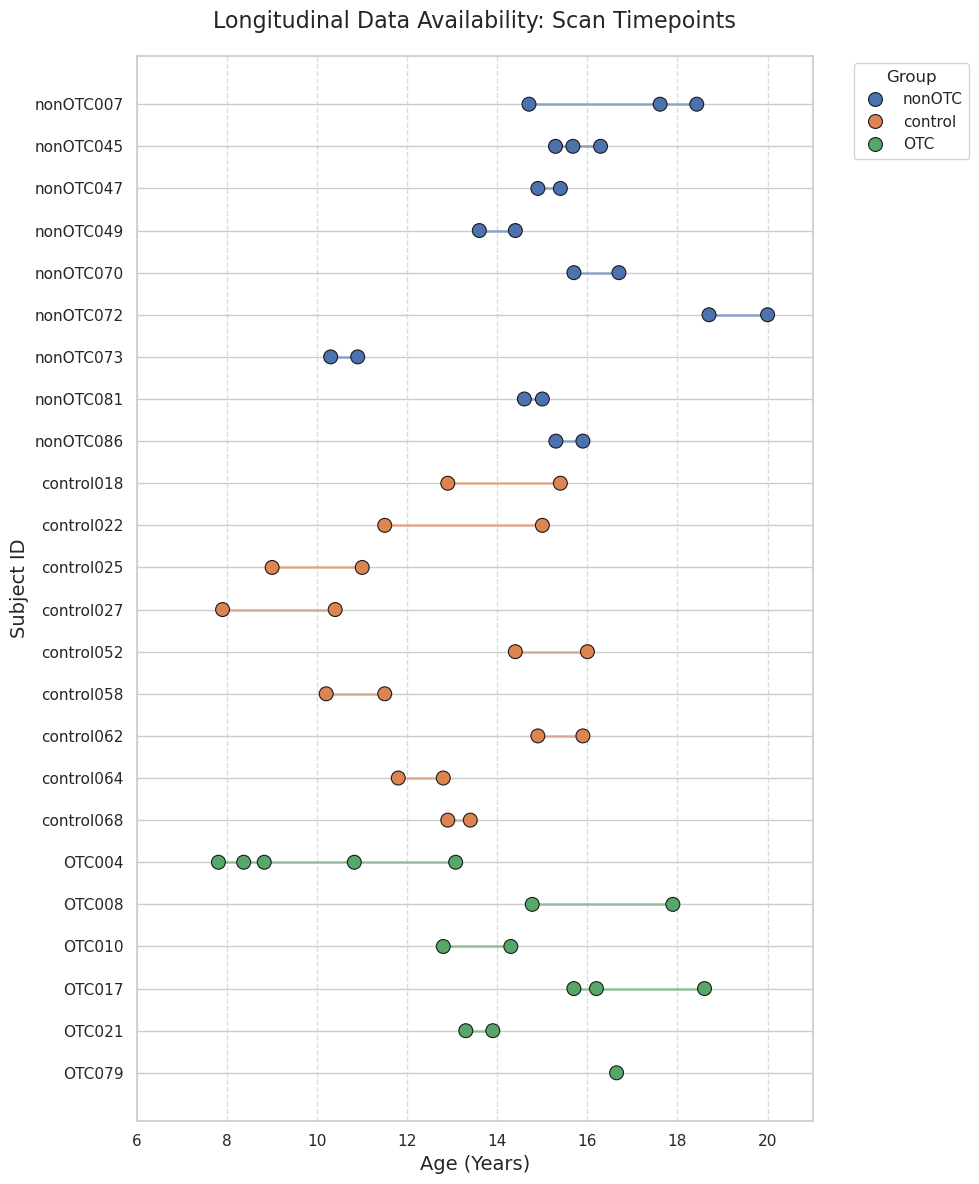

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare the data
# We drop duplicates because we don't need separate points for 'House'/'Object' 
# We just want to know: "Did this subject have a scan at this age?"
timeline_df = df_timepoints[['Subject', 'Age', 'Group']].drop_duplicates()

# Sort by Group first, then Subject ID to keep the Y-axis organized
timeline_df = timeline_df.sort_values(by=['Group', 'Subject'], ascending=[False, True])

# Set up the plot
# Adjust the height (12) based on how many subjects you have
plt.figure(figsize=(10, 12)) 
sns.set_theme(style="whitegrid")

# 2. Draw the connecting lines (The duration of participation)
# We use lineplot with units='Subject' to draw a line from First Scan -> Last Scan
sns.lineplot(
    data=timeline_df,
    x='Age',
    y='Subject',
    hue='Group',
    units='Subject',
    estimator=None,
    linewidth=2,
    alpha=0.5, # Semi-transparent lines so dots pop out
    legend=None 
)

# 3. Draw the specific time points (The Scans)
sns.scatterplot(
    data=timeline_df,
    x='Age',
    y='Subject',
    hue='Group',
    s=100,         # Size of the dots
    edgecolor='k', # Black edge around dots for contrast
    zorder=10      # Force dots to sit on top of the lines
)

# Formatting
plt.title('Longitudinal Data Availability: Scan Timepoints', fontsize=16, pad=20)
plt.xlabel('Age (Years)', fontsize=14)
plt.ylabel('Subject ID', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7) # Vertical grid lines only
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Group')

# Set age range to your requested 7-20 (with a little buffer)
plt.xlim(6, 21)

plt.tight_layout()
plt.show()

In [28]:
import pandas as pd

def find_best_control_matches(df_pairs, patient_group_label='OTC'):
    # 1. PREPARE DATA
    # We only need the timing info, so we drop the distinctiveness data to remove duplicates 
    # (e.g., avoiding separate rows for 'House' and 'Object' for the same timeframes)
    cols_needed = ['Subject', 'Group', 'Age_Baseline', 'Age_Final', 'Time_Gap_Years']
    unique_intervals = df_pairs[cols_needed].drop_duplicates()

    # Split into Patients and Controls
    # Assuming 'Control' is the label for controls. Update if your label is different (e.g., 'CON', 'C')
    patients = unique_intervals[unique_intervals['Group'] == patient_group_label].copy()
    controls = unique_intervals[unique_intervals['Group'] != patient_group_label].copy()
    
    matches = []

    # 2. FIND MATCHES
    for idx, pt_row in patients.iterrows():
        # Calculate differences for ALL controls against this specific patient interval
        candidates = controls.copy()
        
        # Calculate Absolute Errors
        candidates['gap_diff'] = (candidates['Time_Gap_Years'] - pt_row['Time_Gap_Years']).abs()
        candidates['age_diff'] = (candidates['Age_Baseline'] - pt_row['Age_Baseline']).abs()
        
        # 3. RANKING LOGIC
        # Sort primarily by Gap Difference (Time frame is king)
        # Sort secondarily by Age Difference (If gaps are similar, pick the closest age)
        best_matches = candidates.sort_values(by=['gap_diff', 'age_diff'])
        
        # Grab the #1 best match
        best = best_matches.iloc[0]
        
        matches.append({
            # Patient Info
            'Pt_Subject': pt_row['Subject'],
            'Pt_Age_Start': pt_row['Age_Baseline'],
            'Pt_Gap': pt_row['Time_Gap_Years'],
            
            # Control Match Info
            'Match_Control': best['Subject'],
            'Ctl_Age_Start': best['Age_Baseline'],
            'Ctl_Gap': best['Time_Gap_Years'],
            
            # Quality of Match
            'Gap_Difference': best['gap_diff'], # How far off was the duration?
            'Age_Difference': best['age_diff'] # How far off was the age?
        })

    return pd.DataFrame(matches)

# --- EXECUTION ---
# Ensure you use the dataframe from the very first step (all_pairs_combined)
# Replace 'OTC' with whatever string you actually use for the patient group in your CSV
matched_intervals = find_best_control_matches(all_pairs_combined, patient_group_label='OTC')

# Display formatted results
print(f"Found matches for {len(matched_intervals)} patient intervals.\n")

# Show top 10 matches (sorted by how perfect the time gap match is)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Let's print a readable table
print(matched_intervals[['Pt_Subject', 'Pt_Gap', 'Match_Control', 'Ctl_Gap', 'Gap_Difference', 'Age_Difference']].head(15))

# Optional: Check which Control is used the most?
print("\nMost frequently used Control matches:")
print(matched_intervals['Match_Control'].value_counts().head(5))

Found matches for 10 patient intervals.

  Pt_Subject  Pt_Gap Match_Control   Ctl_Gap  Gap_Difference  Age_Difference
0     OTC004   0.456    control068  0.500000        0.044000        4.531000
1     OTC004   2.000    control025  2.000000        0.000000        0.175000
2     OTC004   2.250    control025  2.000000        0.250000        1.825000
3     OTC004   0.561     nonOTC073  0.600000        0.039000        2.492000
4     OTC008   3.122     nonOTC007  2.911000        0.211000        0.072000
5     OTC010   1.500    control052  1.600000        0.100000        1.600000
6     OTC017   0.000     nonOTC045  0.386111        0.386111        0.408333
7     OTC017   0.500     nonOTC047  0.500000        0.000000        0.800000
8     OTC017   2.400    control018  2.500000        0.100000        3.300000
9     OTC021   0.600     nonOTC086  0.600000        0.000000        2.000000

Most frequently used Control matches:
control025    2
control068    1
nonOTC073     1
nonOTC007     1
control05

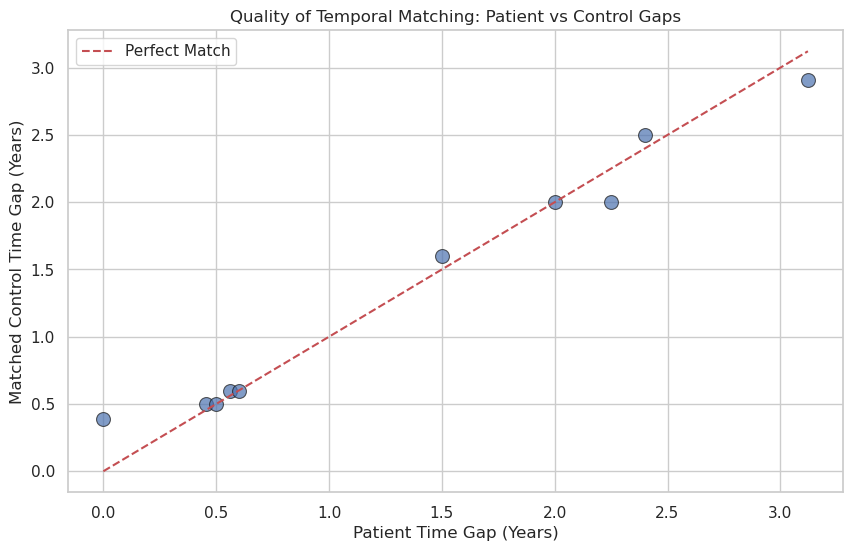

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plot Gap Matching
sns.scatterplot(
    data=matched_intervals,
    x='Pt_Gap',
    y='Ctl_Gap',
    s=100,
    alpha=0.7,
    edgecolor='k'
)

# Add a diagonal identity line (Perfect Match)
max_val = max(matched_intervals['Pt_Gap'].max(), matched_intervals['Ctl_Gap'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Match')

plt.title('Quality of Temporal Matching: Patient vs Control Gaps')
plt.xlabel('Patient Time Gap (Years)')
plt.ylabel('Matched Control Time Gap (Years)')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
import pandas as pd
import numpy as np

def find_best_balanced_matches(df_pairs, patient_group_label='OTC', gap_tolerance=0.25):
    """
    Matches patients to controls prioritizing Time Gap, but optimizing for Age 
    once the time gap is 'close enough' (defined by gap_tolerance).
    """
    
    # 1. PREPARE DATA
    cols = ['Subject', 'Group', 'Age_Baseline', 'Age_Final', 'Time_Gap_Years']
    unique_intervals = df_pairs[cols].drop_duplicates()
    
    # Filter out "zero" gaps (artifacts or same-day scans)
    unique_intervals = unique_intervals[unique_intervals['Time_Gap_Years'] > 0.1]

    patients = unique_intervals[unique_intervals['Group'] == patient_group_label].copy()
    controls = unique_intervals[unique_intervals['Group'] != patient_group_label].copy()
    
    matches = []
    used_controls = set() # To track duplicates if we want to flag them

    for idx, pt_row in patients.iterrows():
        candidates = controls.copy()
        
        # Calculate diffs for ALL controls
        candidates['gap_diff'] = (candidates['Time_Gap_Years'] - pt_row['Time_Gap_Years']).abs()
        candidates['age_diff'] = (candidates['Age_Baseline'] - pt_row['Age_Baseline']).abs()
        
        # --- NEW LOGIC ---
        # Step A: Find candidates within the "Tolerance Window" for time gap (e.g., +/- 3 months)
        good_time_matches = candidates[candidates['gap_diff'] <= gap_tolerance]
        
        best = None
        match_type = ""
        
        if not good_time_matches.empty:
            # Scenario 1: We have controls with similar time gaps. 
            # Pick the one with the BEST AGE match among them.
            best = good_time_matches.sort_values(by='age_diff').iloc[0]
            match_type = "Age Optimized (Good Gap)"
        else:
            # Scenario 2: No controls have a similar time gap.
            # We are forced to just pick the best time gap available, ignoring age.
            best = candidates.sort_values(by='gap_diff').iloc[0]
            match_type = "Gap Optimized (No close match)"
            
        matches.append({
            'Pt_Subject': pt_row['Subject'],
            'Pt_Age': pt_row['Age_Baseline'],
            'Pt_Gap': pt_row['Time_Gap_Years'],
            'Match_Control': best['Subject'],
            'Ctl_Age': best['Age_Baseline'],
            'Ctl_Gap': best['Time_Gap_Years'],
            'Gap_Diff': best['gap_diff'],
            'Age_Diff': best['age_diff'],
            'Match_Type': match_type,
            'Duplicate_Use': best['Subject'] in used_controls
        })
        
        used_controls.add(best['Subject'])

    return pd.DataFrame(matches)

# Run the improved matcher
# gap_tolerance=0.25 means we consider any gap within 3 months to be "equal", 
# allowing us to focus on Age for those cases.
balanced_matches = find_best_balanced_matches(all_pairs_combined, patient_group_label='OTC', gap_tolerance=0.25)

# Display
print(f"Matches found: {len(balanced_matches)}")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(balanced_matches[['Pt_Subject', 'Pt_Gap', 'Match_Control', 'Ctl_Gap', 'Gap_Diff', 'Age_Diff', 'Match_Type']])

# Quick sanity check on average error
print("\n--- Average Errors ---")
print(balanced_matches[['Gap_Diff', 'Age_Diff']].mean())

Matches found: 9
  Pt_Subject  Pt_Gap Match_Control   Ctl_Gap  Gap_Diff  Age_Diff                Match_Type
0     OTC004   0.456     nonOTC073  0.600000  0.144000  1.931000  Age Optimized (Good Gap)
1     OTC004   2.000    control025  2.000000  0.000000  0.175000  Age Optimized (Good Gap)
2     OTC004   2.250    control025  2.000000  0.250000  1.825000  Age Optimized (Good Gap)
3     OTC004   0.561     nonOTC073  0.600000  0.039000  2.492000  Age Optimized (Good Gap)
4     OTC008   3.122     nonOTC007  2.911000  0.211000  0.072000  Age Optimized (Good Gap)
5     OTC010   1.500    control052  1.600000  0.100000  1.600000  Age Optimized (Good Gap)
6     OTC017   0.500     nonOTC045  0.613889  0.113889  0.022222  Age Optimized (Good Gap)
7     OTC017   2.400    control018  2.500000  0.100000  3.300000  Age Optimized (Good Gap)
8     OTC021   0.600     nonOTC049  0.800000  0.200000  0.300000  Age Optimized (Good Gap)

--- Average Errors ---
Gap_Diff    0.128654
Age_Diff    1.301914
dtype: 

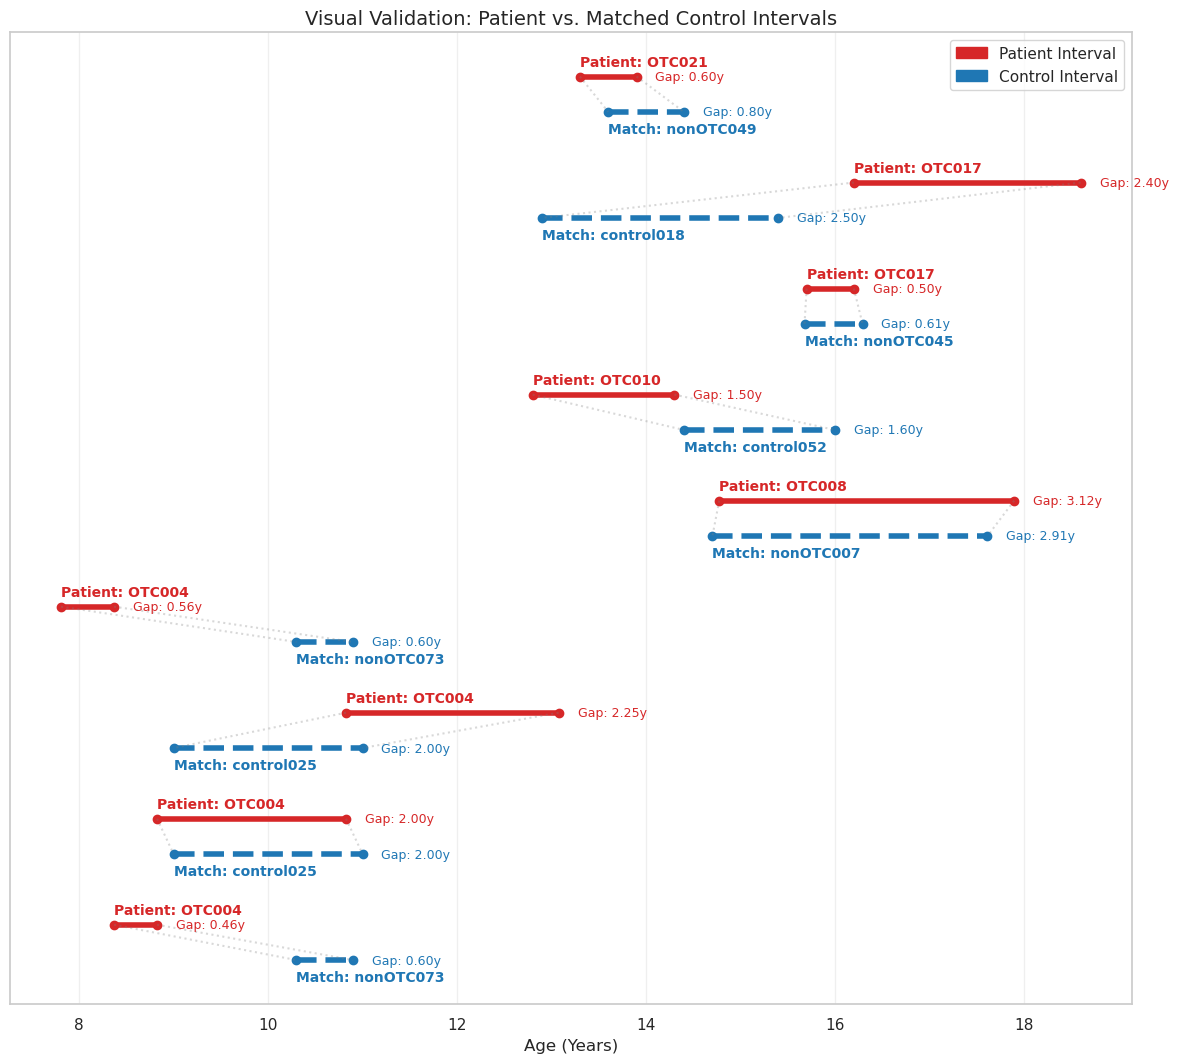

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_matched_pairs(matches_df):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, len(matches_df) * 1.2)) # Dynamic height
    
    # Define colors
    col_pt = '#d62728'  # Red for Patients
    col_ctl = '#1f77b4' # Blue for Controls
    
    # Iterate through matches to plot them
    for idx, row in matches_df.iterrows():
        # Y-positions (grouped by match index)
        y_pt = idx * 3 + 1
        y_ctl = idx * 3
        
        # 1. Plot Patient Interval
        pt_start = row['Pt_Age']
        pt_end = row['Pt_Age'] + row['Pt_Gap']
        ax.plot([pt_start, pt_end], [y_pt, y_pt], color=col_pt, linewidth=4, marker='o')
        
        # Label Patient
        ax.text(pt_start, y_pt + 0.3, f"Patient: {row['Pt_Subject']}", color=col_pt, fontweight='bold', fontsize=10)
        ax.text(pt_end + 0.2, y_pt, f"Gap: {row['Pt_Gap']:.2f}y", color=col_pt, fontsize=9, va='center')

        # 2. Plot Control Interval
        ctl_start = row['Ctl_Age']
        ctl_end = row['Ctl_Age'] + row['Ctl_Gap']
        ax.plot([ctl_start, ctl_end], [y_ctl, y_ctl], color=col_ctl, linewidth=4, marker='o', linestyle='--')
        
        # Label Control
        ax.text(ctl_start, y_ctl - 0.6, f"Match: {row['Match_Control']}", color=col_ctl, fontweight='bold', fontsize=10)
        ax.text(ctl_end + 0.2, y_ctl, f"Gap: {row['Ctl_Gap']:.2f}y", color=col_ctl, fontsize=9, va='center')

        # 3. Draw a connector to show the "Skew" (Age Mismatch)
        # If the lines are vertically aligned, Age Mismatch is 0. 
        # Slanted lines indicate the control is younger/older.
        ax.plot([pt_start, ctl_start], [y_pt, y_ctl], color='gray', alpha=0.3, linestyle=':')
        ax.plot([pt_end, ctl_end], [y_pt, y_ctl], color='gray', alpha=0.3, linestyle=':')

    # Formatting
    ax.set_yticks([])
    ax.set_xlabel('Age (Years)', fontsize=12)
    ax.set_title('Visual Validation: Patient vs. Matched Control Intervals', fontsize=14)
    
    # Custom Legend
    red_patch = mpatches.Patch(color=col_pt, label='Patient Interval')
    blue_patch = mpatches.Patch(color=col_ctl, label='Control Interval')
    plt.legend(handles=[red_patch, blue_patch], loc='upper right')
    
    # Grid
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run the visualizer
plot_matched_pairs(balanced_matches)

In [32]:
import pandas as pd

def find_best_strict_matches(df_pairs, patient_prefix='OTC', control_prefix='control', gap_tolerance=0.25):
    """
    Matches OTC patients ONLY to healthy controls (filtering out nonOTC patients).
    """
    
    # 1. PREPARE DATA
    cols = ['Subject', 'Group', 'Age_Baseline', 'Age_Final', 'Time_Gap_Years']
    unique_intervals = df_pairs[cols].drop_duplicates()
    
    # Filter out "zero" gaps
    unique_intervals = unique_intervals[unique_intervals['Time_Gap_Years'] > 0.1]

    # --- STRICT FILTERING ---
    # Patients: Must start with 'OTC' (or match your patient group label)
    patients = unique_intervals[unique_intervals['Subject'].str.startswith(patient_prefix)].copy()
    
    # Controls: Must start with 'control' (Strictly excluding 'nonOTC')
    controls = unique_intervals[unique_intervals['Subject'].str.startswith(control_prefix)].copy()
    
    matches = []
    used_controls = set() 

    for idx, pt_row in patients.iterrows():
        candidates = controls.copy()
        
        if len(candidates) == 0:
            print("WARNING: No healthy controls found! Check your data/prefixes.")
            break

        # Calculate diffs
        candidates['gap_diff'] = (candidates['Time_Gap_Years'] - pt_row['Time_Gap_Years']).abs()
        candidates['age_diff'] = (candidates['Age_Baseline'] - pt_row['Age_Baseline']).abs()
        
        # --- MATCHING LOGIC (Same as before) ---
        # Step A: Find candidates within 3 months (0.25 years) of the gap
        good_time_matches = candidates[candidates['gap_diff'] <= gap_tolerance]
        
        best = None
        match_type = ""
        
        if not good_time_matches.empty:
            # Prioritize Age if gap is good
            best = good_time_matches.sort_values(by='age_diff').iloc[0]
            match_type = "Age Optimized (Good Gap)"
        else:
            # Fallback to best gap
            best = candidates.sort_values(by='gap_diff').iloc[0]
            match_type = "Gap Optimized (No close match)"
            
        matches.append({
            'Pt_Subject': pt_row['Subject'],
            'Pt_Age': pt_row['Age_Baseline'],
            'Pt_Gap': pt_row['Time_Gap_Years'],
            'Match_Control': best['Subject'],
            'Ctl_Age': best['Age_Baseline'],
            'Ctl_Gap': best['Time_Gap_Years'],
            'Gap_Diff': best['gap_diff'],
            'Age_Diff': best['age_diff'],
            'Match_Type': match_type,
            'Duplicate_Use': best['Subject'] in used_controls
        })
        
        used_controls.add(best['Subject'])

    return pd.DataFrame(matches)

# --- EXECUTION ---
# We define the prefixes explicitly to ensure we grab the right people
strict_matches = find_best_strict_matches(
    all_pairs_combined, 
    patient_prefix='OTC', 
    control_prefix='control', # This ensures 'nonOTC' is ignored
    gap_tolerance=0.25
)

print(f"Matches found: {len(strict_matches)}")
if len(strict_matches) > 0:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(strict_matches[['Pt_Subject', 'Pt_Gap', 'Match_Control', 'Ctl_Gap', 'Gap_Diff', 'Age_Diff', 'Match_Type']])

    print("\n--- Average Errors (Healthy Controls Only) ---")
    print(strict_matches[['Gap_Diff', 'Age_Diff']].mean())

Matches found: 9
  Pt_Subject  Pt_Gap Match_Control  Ctl_Gap  Gap_Diff  Age_Diff                      Match_Type
0     OTC004   0.456    control068      0.5     0.044     4.531        Age Optimized (Good Gap)
1     OTC004   2.000    control025      2.0     0.000     0.175        Age Optimized (Good Gap)
2     OTC004   2.250    control025      2.0     0.250     1.825        Age Optimized (Good Gap)
3     OTC004   0.561    control068      0.5     0.061     5.092        Age Optimized (Good Gap)
4     OTC008   3.122    control022      3.5     0.378     3.275  Gap Optimized (No close match)
5     OTC010   1.500    control052      1.6     0.100     1.600        Age Optimized (Good Gap)
6     OTC017   0.500    control068      0.5     0.000     2.800        Age Optimized (Good Gap)
7     OTC017   2.400    control018      2.5     0.100     3.300        Age Optimized (Good Gap)
8     OTC021   0.600    control068      0.5     0.100     0.400        Age Optimized (Good Gap)

--- Average Errors (He

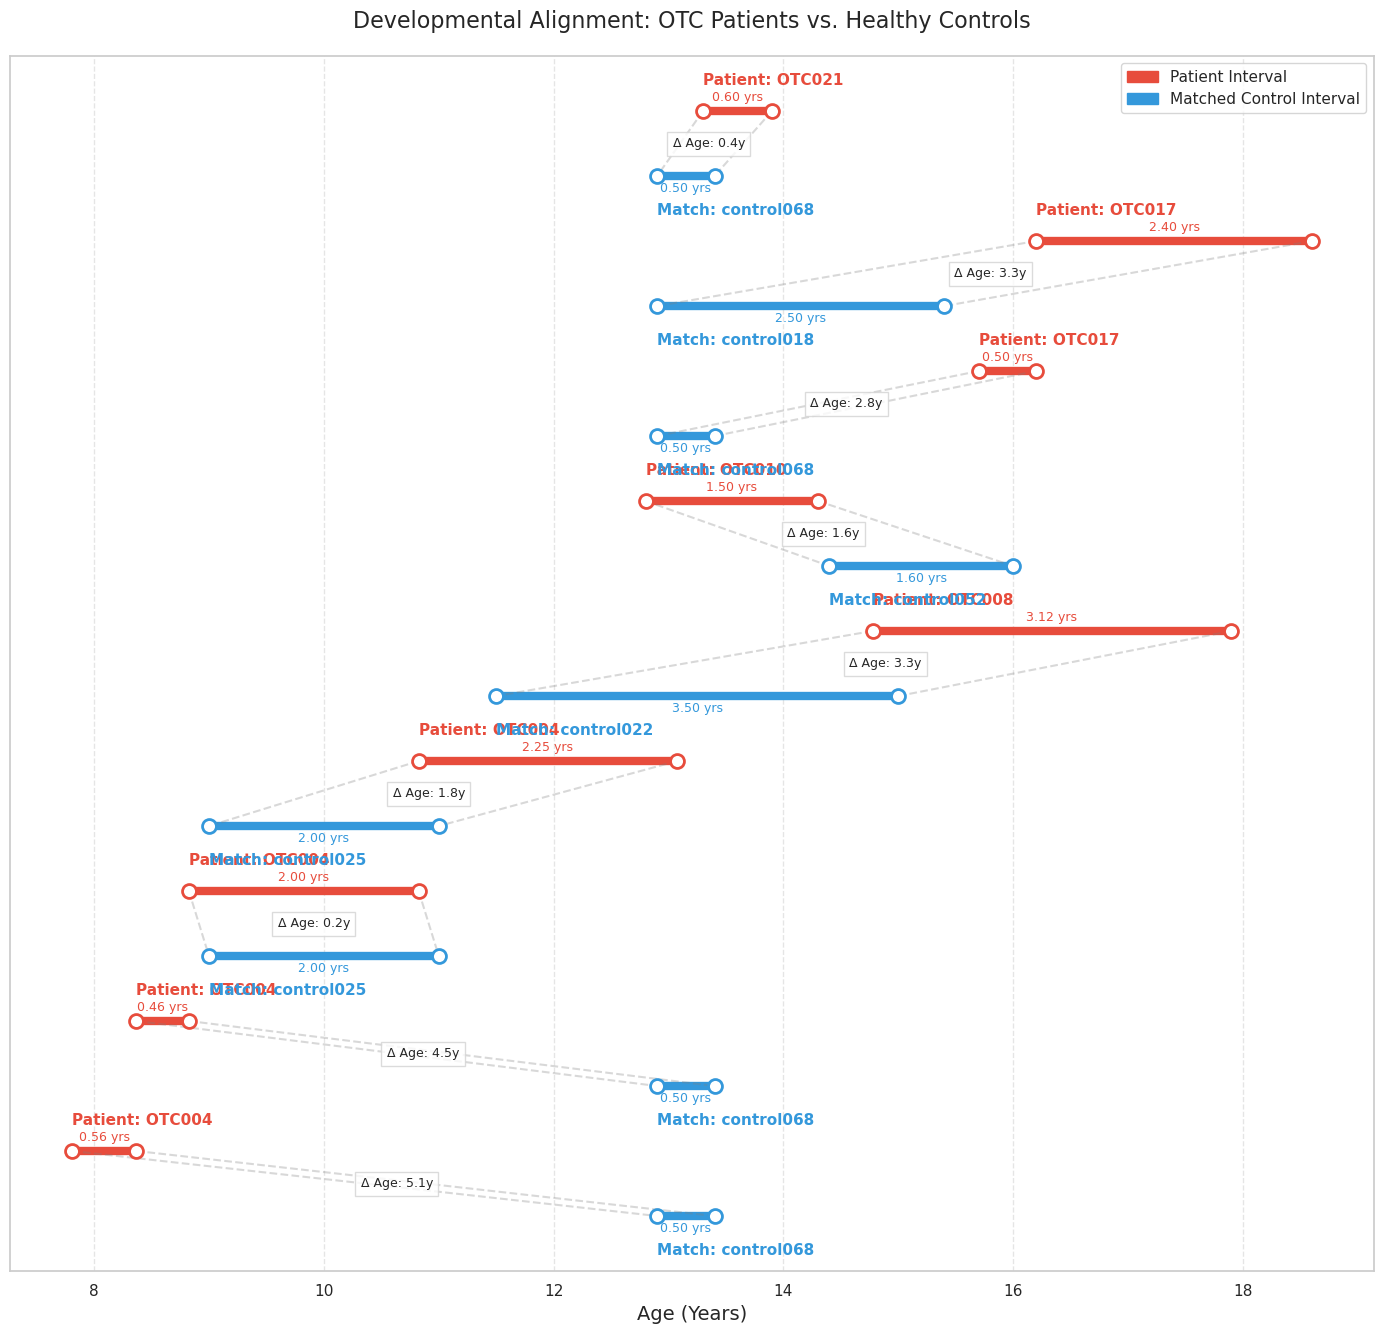

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_strict_matches(matches_df):
    # Create figure
    fig, ax = plt.subplots(figsize=(14, len(matches_df) * 1.5))
    
    # Colors
    col_pt = '#e74c3c'  # Red for Patient
    col_ctl = '#3498db' # Blue for Control
    
    # Sort by Patient Subject for cleaner grouping
    df_sorted = matches_df.sort_values(by=['Pt_Subject', 'Pt_Age'])
    
    for i, (idx, row) in enumerate(df_sorted.iterrows()):
        # Y-coordinate for this pair
        y_base = i * 4
        
        # --- 1. Patient Bar (Top) ---
        pt_start = row['Pt_Age']
        pt_end = pt_start + row['Pt_Gap']
        
        # Draw the interval line
        ax.plot([pt_start, pt_end], [y_base + 1, y_base + 1], 
                color=col_pt, linewidth=6, solid_capstyle='round')
        
        # Draw endpoints
        ax.scatter([pt_start, pt_end], [y_base + 1, y_base + 1], 
                   color='white', edgecolor=col_pt, s=100, zorder=10, linewidth=2)
        
        # Text Labels
        ax.text(pt_start, y_base + 1.8, f"Patient: {row['Pt_Subject']}", 
                color=col_pt, fontweight='bold', fontsize=11)
        ax.text((pt_start + pt_end)/2, y_base + 1.3, f"{row['Pt_Gap']:.2f} yrs", 
                color=col_pt, ha='center', fontsize=9)

        # --- 2. Control Bar (Bottom) ---
        ctl_start = row['Ctl_Age']
        ctl_end = ctl_start + row['Ctl_Gap']
        
        # Draw the interval line
        ax.plot([ctl_start, ctl_end], [y_base - 1, y_base - 1], 
                color=col_ctl, linewidth=6, solid_capstyle='round')
        
        # Draw endpoints
        ax.scatter([ctl_start, ctl_end], [y_base - 1, y_base - 1], 
                   color='white', edgecolor=col_ctl, s=100, zorder=10, linewidth=2)
        
        # Text Labels
        ax.text(ctl_start, y_base - 2.2, f"Match: {row['Match_Control']}", 
                color=col_ctl, fontweight='bold', fontsize=11)
        ax.text((ctl_start + ctl_end)/2, y_base - 1.5, f"{row['Ctl_Gap']:.2f} yrs", 
                color=col_ctl, ha='center', fontsize=9)

        # --- 3. Connector Lines (Visualizing the Error) ---
        # Connect Starts
        ax.plot([pt_start, ctl_start], [y_base + 1, y_base - 1], 
                color='gray', linestyle='--', alpha=0.3)
        # Connect Ends
        ax.plot([pt_end, ctl_end], [y_base + 1, y_base - 1], 
                color='gray', linestyle='--', alpha=0.3)
        
        # Annotate the Age Difference
        mid_x = (max(pt_start, ctl_start) + min(pt_end, ctl_end)) / 2
        ax.text(mid_x, y_base, f"Δ Age: {row['Age_Diff']:.1f}y", 
                ha='center', va='center', fontsize=9, 
                bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.8))

    # Formatting
    ax.set_yticks([])
    ax.set_xlabel('Age (Years)', fontsize=14)
    ax.set_title('Developmental Alignment: OTC Patients vs. Healthy Controls', fontsize=16, pad=20)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Legend
    legend_elements = [
        mpatches.Patch(color=col_pt, label='Patient Interval'),
        mpatches.Patch(color=col_ctl, label='Matched Control Interval')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Run visualization on your existing dataframe
visualize_strict_matches(strict_matches)

Matches found (OTC vs non-OTC): 9
  Pt_Subject  Pt_Gap Match_Control   Ctl_Gap  Gap_Diff  Age_Diff                      Match_Type
0     OTC004   0.456     nonOTC073  0.600000  0.144000  1.931000        Age Optimized (Good Gap)
1     OTC004   2.000     nonOTC072  1.300000  0.700000  9.875000  Gap Optimized (No close match)
2     OTC004   2.250     nonOTC007  2.911000  0.661000  3.878000  Gap Optimized (No close match)
3     OTC004   0.561     nonOTC073  0.600000  0.039000  2.492000        Age Optimized (Good Gap)
4     OTC008   3.122     nonOTC007  2.911000  0.211000  0.072000        Age Optimized (Good Gap)
5     OTC010   1.500     nonOTC072  1.300000  0.200000  5.900000        Age Optimized (Good Gap)
6     OTC017   0.500     nonOTC045  0.613889  0.113889  0.022222        Age Optimized (Good Gap)
7     OTC017   2.400     nonOTC007  2.911000  0.511000  1.497000  Gap Optimized (No close match)
8     OTC021   0.600     nonOTC049  0.800000  0.200000  0.300000        Age Optimized (Good G

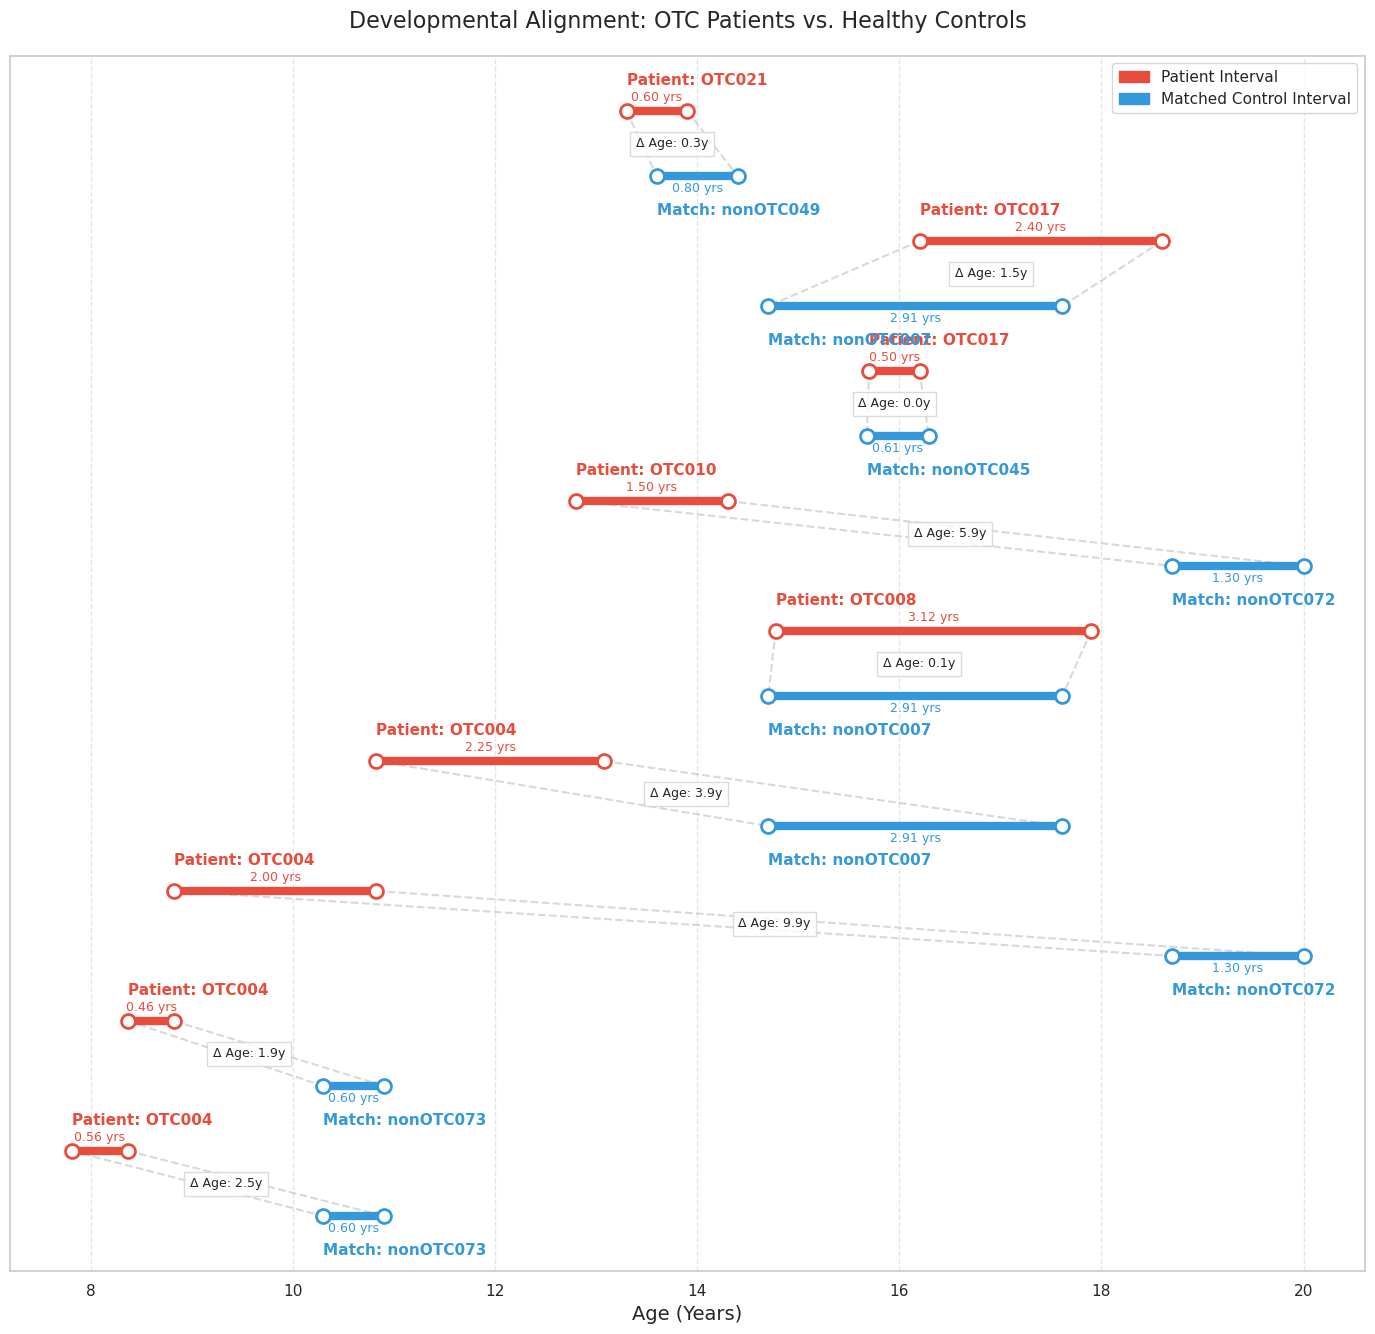

In [34]:
# 1. Run the matching logic
# We simply change the control_prefix to look for "nonOTC" subjects
non_otc_matches = find_best_strict_matches(
    all_pairs_combined, 
    patient_prefix='OTC', 
    control_prefix='nonOTC',  # <--- The only change needed
    gap_tolerance=0.25
)

# 2. Display the Table
print(f"Matches found (OTC vs non-OTC): {len(non_otc_matches)}")
if len(non_otc_matches) > 0:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(non_otc_matches[['Pt_Subject', 'Pt_Gap', 'Match_Control', 'Ctl_Gap', 'Gap_Diff', 'Age_Diff', 'Match_Type']])

    # 3. Check the Error Stats
    print("\n--- Average Errors (Non-OTC Patients) ---")
    print(non_otc_matches[['Gap_Diff', 'Age_Diff']].mean())

    # 4. Visualize the Alignment
    # We can reuse the visualization function we defined in the previous step
    print("\nGenerating visualization...")
    visualize_strict_matches(non_otc_matches)

In [36]:
# Generate matches (you already have these)
otc_control = find_best_strict_matches(all_pairs_combined, 'OTC', 'control', 0.25)
otc_nonotc = find_best_strict_matches(all_pairs_combined, 'OTC', 'nonOTC', 0.25)

# Rename columns for clarity
otc_control = otc_control.rename(columns={
    'Match_Control': 'Control_Match', 'Ctl_Age': 'Control_Age', 'Ctl_Gap': 'Control_Gap',
    'Gap_Diff': 'Control_Gap_Diff', 'Age_Diff': 'Control_Age_Diff'
})

otc_nonotc = otc_nonotc.rename(columns={
    'Match_Control': 'NonOTC_Match', 'Ctl_Age': 'NonOTC_Age', 'Ctl_Gap': 'NonOTC_Gap',
    'Gap_Diff': 'NonOTC_Gap_Diff', 'Age_Diff': 'NonOTC_Age_Diff'
})

# Merge on patient info
wide = otc_control.merge(otc_nonotc, on=['Pt_Subject', 'Pt_Age', 'Pt_Gap'], 
                         suffixes=('', '_dup')).drop(columns=[c for c in otc_control.columns if '_dup' in c])

# Save
wide.to_csv('/user_data/csimmon2/git_repos/long_pt/otc_matched_intervals.csv', index=False)
print(f"Saved {len(wide)} intervals")
print(wide.head())

Saved 9 intervals
  Pt_Subject  Pt_Age  Pt_Gap Control_Match  Control_Age  Control_Gap  Control_Gap_Diff  Control_Age_Diff                      Match_Type  Duplicate_Use NonOTC_Match  NonOTC_Age  NonOTC_Gap  NonOTC_Gap_Diff  NonOTC_Age_Diff                  Match_Type_dup  Duplicate_Use_dup
0     OTC004   8.369   0.456    control068         12.9          0.5             0.044             4.531        Age Optimized (Good Gap)          False    nonOTC073      10.300       0.600            0.144            1.931        Age Optimized (Good Gap)              False
1     OTC004   8.825   2.000    control025          9.0          2.0             0.000             0.175        Age Optimized (Good Gap)          False    nonOTC072      18.700       1.300            0.700            9.875  Gap Optimized (No close match)              False
2     OTC004  10.825   2.250    control025          9.0          2.0             0.250             1.825        Age Optimized (Good Gap)           True    nonOT